In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.cluster import DBSCAN
import lightgbm as lgb
from catboost import CatBoostClassifier
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from scipy.stats import chi2_contingency, shapiro, levene, kruskal



## 4. Análisis de los datos.
### 4.1. Aplica un modelo supervisado y uno no supervisado a los datos y comenta los resultados obtenidos.


In [3]:
data = pd.read_csv("../data/data_clean_v2.csv")
data

,cfr,nombre,fc_alta_rgfp,eslora_total,arqueo_gt,material_casco,potencia_kw,estado_rgfp,fc_estado,Puerto,Provincia,Comunidad Autónoma,Tipo de Arte,Edad_buque
0,ESP000000001,ARGOÑOS,1989-05-10,19.31,52.700000,Madera,202.26,Baja Definitiva,1998-12-02,Vicedo,Lugo,Galicia,Cerco,9
1,ESP000000002,MARIA INSOLINA,1989-05-10,10.75,4.287333,Madera,35.30,Baja Definitiva,1990-06-30,Santander,Cantabria,Cantabria,Artes menores,1
2,ESP000000003,MOWINKEL II,1989-05-10,11.25,6.760000,Madera,44.13,Baja Definitiva,2005-02-16,Ceuta,Ceuta,Ceuta,Palangre,15
3,ESP000000004,JULIA NUMERO TRES,1989-05-10,9.15,6.622667,Madera,44.13,Baja Definitiva,1994-08-26,Santander,Cantabria,Cantabria,Artes fijas,5
4,ESP000000005,SIEMPRE HERMANOS EZQUIAGA,1989-05-10,19.60,40.000000,Madera,169.16,Baja Definitiva,2006-11-15,Bermeo,Bizkaia,País Vasco,Artes menores,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27359,GBR000C20512,LODAIRO,2018-10-16,86.10,4290.000000,Acero,4000.00,Alta Definitiva,2019-08-06,Vigo,Pontevedra,Galicia,Arrastre,6
27360,IRL000I14607,ALANNAH RILEY,2021-04-22,28.62,374.000000,Acero,709.00,Baja Definitiva,2024-09-18,Vigo,Pontevedra,Galicia,Arrastre,3
27361,PRT000019293,JOSE Y RAFAELA,2017-08-30,29.46,167.000000,Acero,415.56,Alta Definitiva,2017-08-30,Santa Pola,Alicante,Comunitat Valenciana,Artes menores,7
27362,PRT000020349,BRESO UNO,2016-11-21,23.00,131.000000,Acero,261.03,Alta Definitiva,2016-12-19,Burela,Lugo,Galicia,Artes fijas,8


In [4]:
# ELIMINAR columnas fecha
data.drop(columns=["fc_alta_rgfp", "fc_estado"], inplace=True)
ids = data[["cfr", "nombre"]]

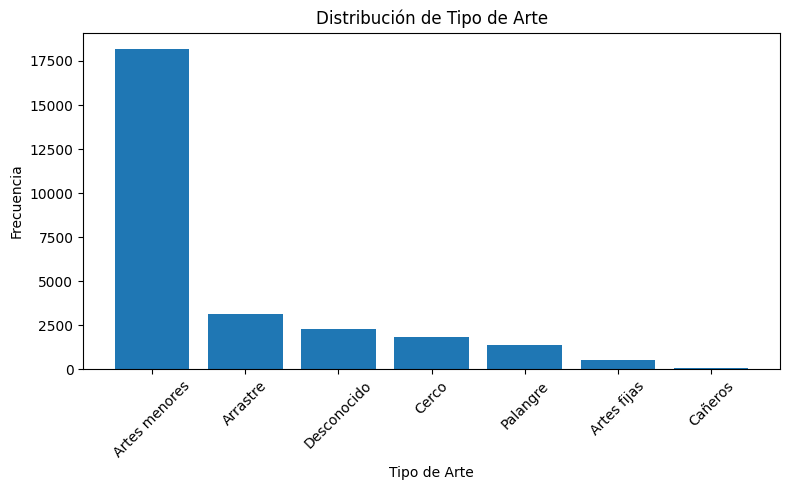

In [4]:
# Visualización del target
target = "Tipo de Arte"

conteo = data[target].value_counts()

# Visualización
plt.figure(figsize=(8, 5))
plt.bar(conteo.index, conteo.values)
plt.xlabel(target)
plt.ylabel("Frecuencia")
plt.title(f"Distribución de {target}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

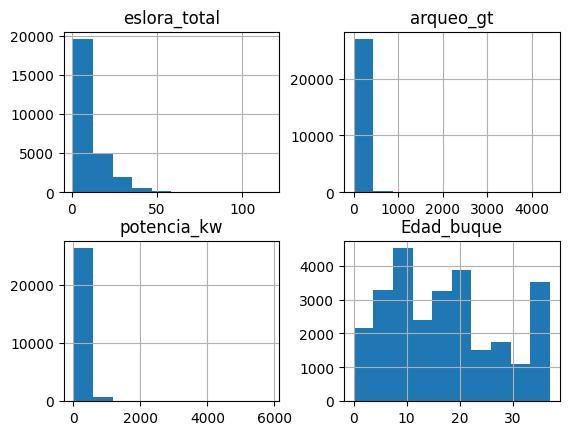

In [5]:
# Comprobar normalidad de las variables numéricas
data.hist();

In [6]:
numeric_cols = data.select_dtypes(include=[np.number]).columns
categoric_cols = data.select_dtypes(exclude=[np.number]).drop(columns= [target, "cfr", "nombre"]).columns 


In [7]:
# Separación de los conjuntos de train y test
X = data.drop(columns=[target, "cfr", "nombre"])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [8]:
# Normalizar las variables numéricas

normalizar = [col for col in numeric_cols if col != 'Edad_buque']
X_train[normalizar] = np.log(X_train[normalizar])
X_test[normalizar] = np.log(X_test[normalizar])

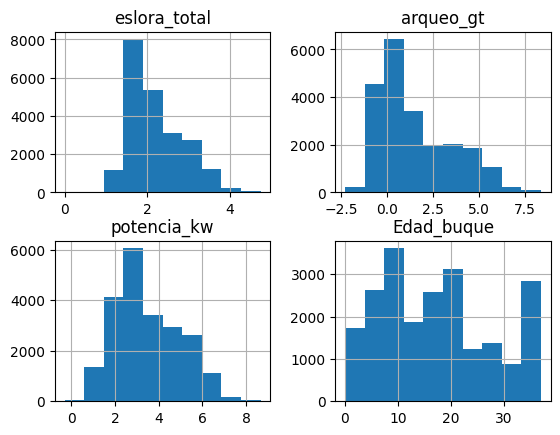

In [9]:
X_train.hist();

In [10]:
# Estandarizar las variables numéricas
scaler = StandardScaler()

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [11]:
# Variables categoricas
X_train = pd.get_dummies(X_train, columns = categoric_cols)
X_test = pd.get_dummies(X_test, columns = categoric_cols)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [12]:
X_train.head()

,eslora_total,arqueo_gt,potencia_kw,Edad_buque,material_casco_-,material_casco_Acero,material_casco_Aluminio,material_casco_Fibra de Vidrio/Plástico,material_casco_Madera,material_casco_Madera forrada de Fibra,...,Comunidad Autónoma_Canarias,Comunidad Autónoma_Cantabria,Comunidad Autónoma_Cataluña,Comunidad Autónoma_Ceuta,Comunidad Autónoma_Comunitat Valenciana,Comunidad Autónoma_Galicia,Comunidad Autónoma_Illes balears,Comunidad Autónoma_Melilla,Comunidad Autónoma_Murcia,Comunidad Autónoma_País Vasco
1647,2.253812,2.350627,2.206875,-1.274435,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16661,-0.437211,-0.295791,-0.467431,0.638509,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
13,1.813216,1.684972,1.484563,-0.604905,False,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False
9166,1.692959,1.753181,1.757437,-1.465730,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
18564,-0.169584,-0.389223,-0.641094,-0.031022,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
models = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("LightGBM", lgb.LGBMClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(verbose=0, random_state=42))
]


for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = balanced_accuracy_score(y_test, y_pred)
    print(f"{name} balanced accuracy: {acc:.4f}")

Decision Tree balanced accuracy: 0.5900
Random Forest balanced accuracy: 0.6258
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 21891, number of used features: 254
[LightGBM] [Info] Start training from score -2.173793
[LightGBM] [Info] Start training from score -3.939392
[LightGBM] [Info] Start training from score -0.408485
[LightGBM] [Info] Start training from score -6.209641
[LightGBM] [Info] Start training from score -2.717274
[LightGBM] [Info] Start training from score -2.477398
[LightGBM] [Info] Start training from score -2.993496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM balanced accuracy: 0.6668
CatBoost balanced accuracy: 0.6414


In [14]:
# Mejor modelo lightgbm
lgbm = [m for n, m in models if n == "LightGBM"][0]

# Optimización de hiperparámetros
param_grid = {
    'num_leaves': [30, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200]
}

# GridSearch con validación 3-fold
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='balanced_accuracy',  
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Entrenamiento con búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)

# Mejor modelo entrenado
best_lgbm = grid_search.best_estimator_

# Predicción en test
y_pred = best_lgbm.predict(X_test)

# Reporte de clasificación
print(classification_report(y_test, y_pred,))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 21891, number of used features: 254
[LightGBM] [Info] Start training from score -2.173793
[LightGBM] [Info] Start training from score -3.939392
[LightGBM] [Info] Start training from score -0.408485
[LightGBM] [Info] Start training from score -6.209641
[LightGBM] [Info] Start training from score -2.717274
[LightGBM] [Info] Start training from score -2.477398
[LightGBM] [Info] Start training from score -2.993496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

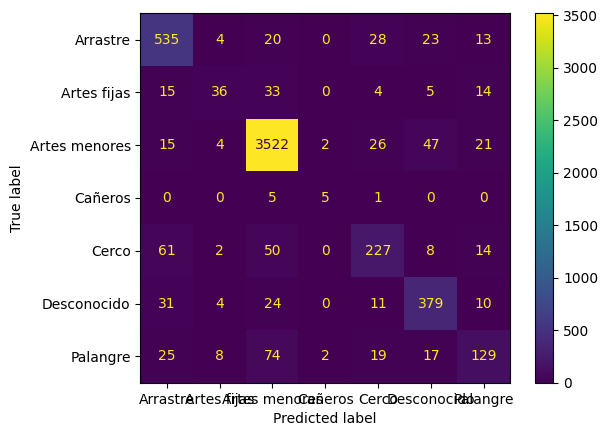

In [15]:

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [16]:
# Aplicando ReSampling:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Distribución original:", Counter(y_train))
print("Distribución tras SMOTE:", Counter(y_train_resampled))

Distribución original: Counter({'Artes menores': 14550, 'Arrastre': 2490, 'Desconocido': 1838, 'Cerco': 1446, 'Palangre': 1097, 'Artes fijas': 426, 'Cañeros': 44})
Distribución tras SMOTE: Counter({'Desconocido': 14550, 'Artes menores': 14550, 'Arrastre': 14550, 'Cerco': 14550, 'Palangre': 14550, 'Artes fijas': 14550, 'Cañeros': 14550})


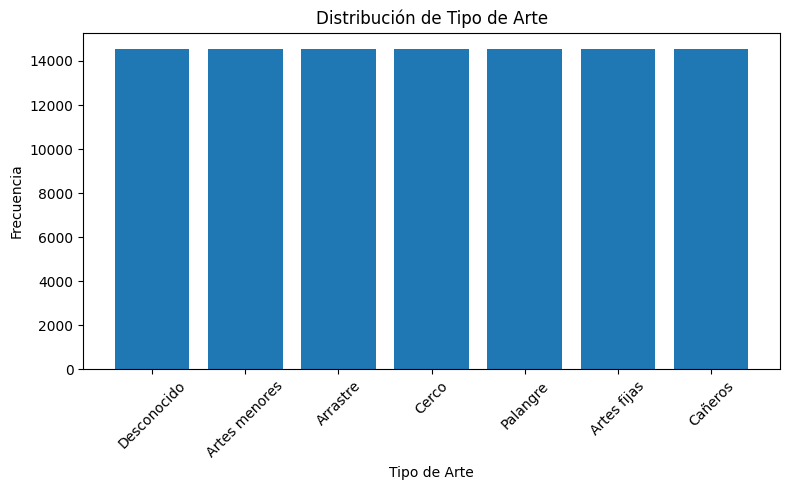

In [17]:
conteo = y_train_resampled.value_counts()

# Visualización
plt.figure(figsize=(8, 5))
plt.bar(conteo.index, conteo.values)
plt.xlabel(target)
plt.ylabel("Frecuencia")
plt.title(f"Distribución de {target}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
best_lgbm.fit(X_train_resampled, y_train_resampled)
y_pred = best_lgbm.predict(X_test)

print(classification_report(y_test, y_pred,))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1594
[LightGBM] [Info] Number of data points in the train set: 101850, number of used features: 291
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
               precision    recall  f1-score   support

     Arrastre       0.81      0.80      0.80       623
  Artes fijas       0.42      0.61      0.49       107
Artes menores       0

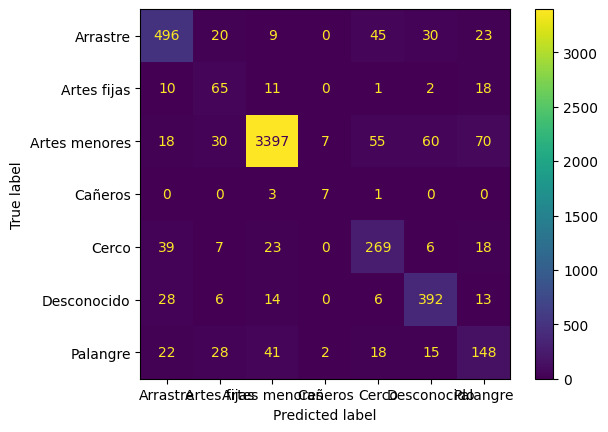

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [20]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_resampled)
y_test_enc = le.transform(y_test)

In [21]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=356, activation='relu', input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dropout(0.2)) 
model.add(keras.layers.Dense(units=264, activation='relu'))
model.add(keras.layers.Dropout(0.2)) 
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(units=len(np.unique(y_train)), activation='softmax'))

# Compilamos el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo
history = model.fit(X_train_resampled, y_train_enc, epochs=250, batch_size=364, validation_split=0.2, verbose=1, callbacks= [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)])

# Evaluamos el modelo en el set de test
test_loss, test_accuracy = model.evaluate(X_test, y_test_enc)
print(f"Accuracy en test: {test_accuracy:.4f}")

c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/250
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7081 - loss: 0.8324 - val_accuracy: 0.2953 - val_loss: 2.1365
Epoch 2/250
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8821 - loss: 0.3222 - val_accuracy: 0.3434 - val_loss: 2.1094
Epoch 3/250
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8996 - loss: 0.2732 - val_accuracy: 0.3983 - val_loss: 1.5995
Epoch 4/250
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9111 - loss: 0.2476 - val_accuracy: 0.4143 - val_loss: 1.7261
Epoch 5/250
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9162 - loss: 0.2311 - val_accuracy: 0.4673 - val_loss: 1.4611
Epoch 6/250
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9220 - loss: 0.2156 - val_accuracy: 0.4749 - val_loss: 1.4101
Epoch 7/250
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9249 - loss: 0.2111 - val_accuracy: 0.4972 - val_loss: 1.4214
Epoch 8/250
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9286 - loss: 0.1985 - val_accu

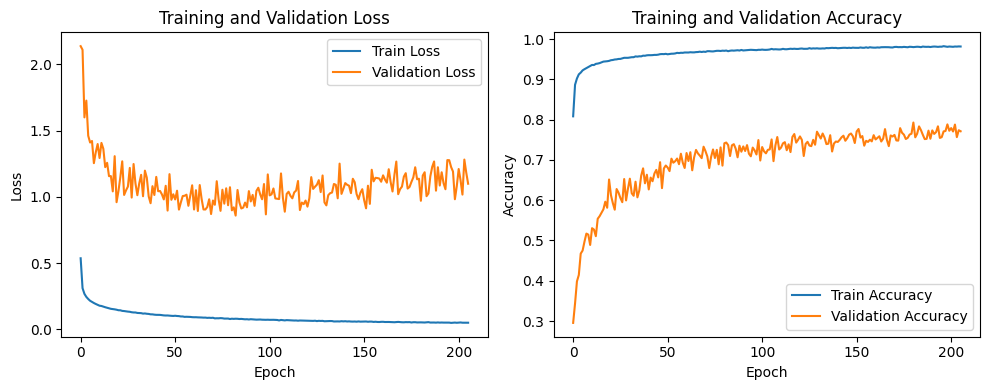

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Plot de pérdida (loss)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot de accuracy
    plt.subplot(1, 2, 2)
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [23]:
y_pred_probs = model.predict(X_test)

# Elegimos la clase con mayor probabilidad
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(le.inverse_transform(y_test_enc), le.inverse_transform(y_pred)))


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
               precision    recall  f1-score   support

     Arrastre       0.76      0.81      0.79       623
  Artes fijas       0.41      0.46      0.43       107
Artes menores       0.96      0.94      0.95      3637
      Cañeros       0.50      0.55      0.52        11
        Cerco       0.67      0.65      0.66       362
  Desconocido       0.71      0.83      0.77       459
     Palangre       0.47      0.36      0.41       274

     accuracy                           0.86      5473
    macro avg       0.64      0.66      0.65      5473
 weighted avg       0.86      0.86      0.86      5473



In [24]:
# Mejor modelo lightGBM
pickle.dump(best_lgbm, open('modelo_supervisado.pkl', 'wb'))


In [13]:
# No supervisado
#categoric_cols = categoric_cols.append(target)

scaler_2 = StandardScaler()
numeric_scaled = pd.DataFrame(scaler.fit_transform(data[numeric_cols]), columns=numeric_cols, index=data.index)

categoric_cols = data.select_dtypes(exclude=[np.number]).drop(columns= ["cfr", "nombre"]).columns 
categoric_encoded = pd.get_dummies(data[categoric_cols])

data_preprocessed = pd.concat([numeric_scaled, categoric_encoded], axis=1)

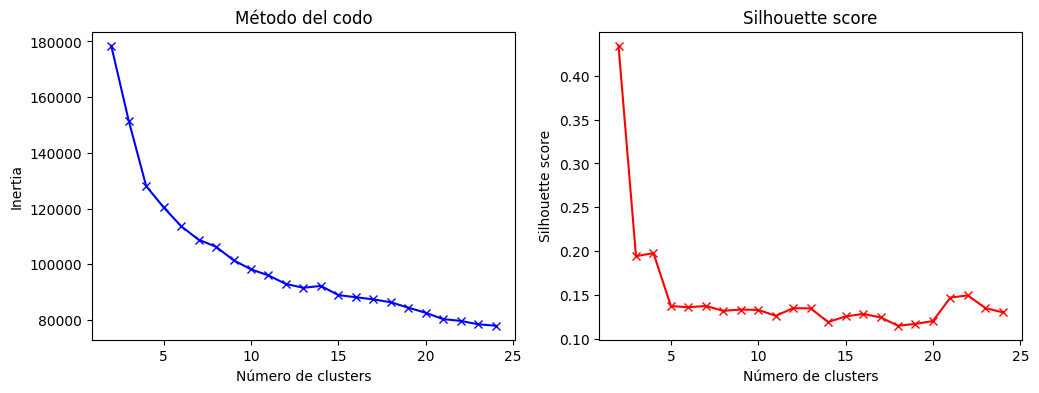

In [26]:


inertia = []
silhouette = []

for k in range(2, 25):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(data_preprocessed)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(data_preprocessed, km.labels_))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(2,25), inertia, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.title('Método del codo')

plt.subplot(1,2,2)
plt.plot(range(2,25), silhouette, 'rx-')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score')
plt.show()

In [14]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(data_preprocessed)

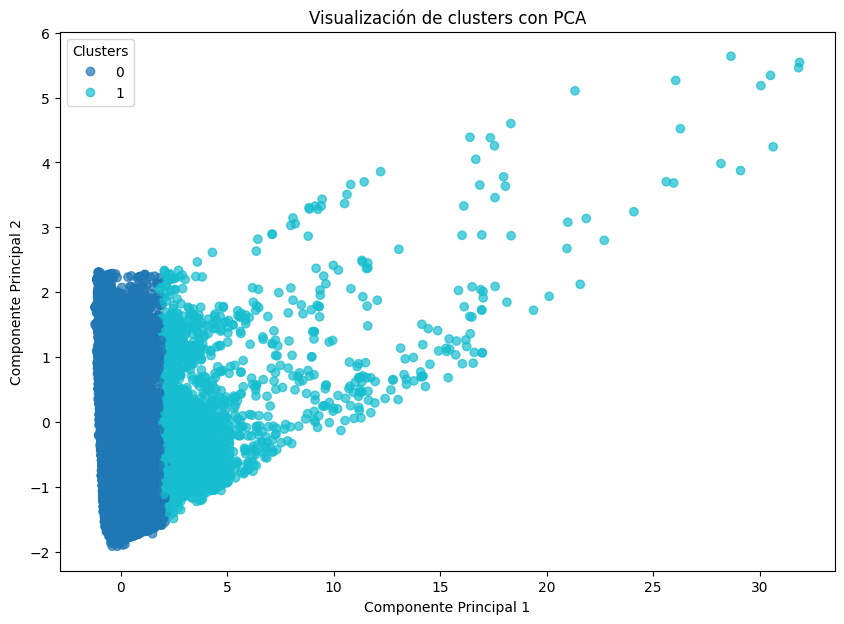

In [28]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(data_preprocessed)

# 2. Crear un DataFrame para la visualización
import pandas as pd
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['cluster'] = clusters

# 3. Graficar los clusters
plt.figure(figsize=(10,7))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster'], cmap='tab10', alpha=0.7)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de clusters con PCA')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [29]:

result_df = pd.concat([data.reset_index(drop=True), pca_df], axis=1)

result_df[['cluster'] + list(data.columns)].head()
result_df.drop(columns= ["PC1", "PC2"], inplace= True)
cluster_1 = result_df[result_df["cluster"]==1]
cluster_1.head()

,cfr,nombre,eslora_total,arqueo_gt,material_casco,potencia_kw,estado_rgfp,Puerto,Provincia,Comunidad Autónoma,Tipo de Arte,Edad_buque,cluster
21,ESP000000022,LOSADA,29.00,132.0,Madera,441.30,Baja Definitiva,Santander,Cantabria,Cantabria,Arrastre,10,1
25,ESP000000026,CHAROLAIS,30.80,202.0,Acero,397.17,Baja Definitiva,Santander,Cantabria,Cantabria,Arrastre,17,1
27,ESP000000028,CARBAL PRIMERO,31.85,241.0,Acero,441.30,Baja Definitiva,Vigo,Pontevedra,Galicia,Artes fijas,21,1
31,ESP000000032,FRANPER,28.00,416.0,Acero,360.39,Baja Definitiva,Santander,Cantabria,Cantabria,Artes fijas,10,1
34,ESP000000036,SIEMPRE ROSINA ANGEL,26.76,130.0,Madera,514.85,Baja Definitiva,Santa Eugenia de Riveira,A Coruña,Galicia,Arrastre,8,1


In [30]:
cluster_0 = result_df[result_df["cluster"]==0]
cluster_0.head()

,cfr,nombre,eslora_total,arqueo_gt,material_casco,potencia_kw,estado_rgfp,Puerto,Provincia,Comunidad Autónoma,Tipo de Arte,Edad_buque,cluster
0,ESP000000001,ARGOÑOS,19.31,52.700000,Madera,202.26,Baja Definitiva,Vicedo,Lugo,Galicia,Cerco,9,0
1,ESP000000002,MARIA INSOLINA,10.75,4.287333,Madera,35.30,Baja Definitiva,Santander,Cantabria,Cantabria,Artes menores,1,0
2,ESP000000003,MOWINKEL II,11.25,6.760000,Madera,44.13,Baja Definitiva,Ceuta,Ceuta,Ceuta,Palangre,15,0
3,ESP000000004,JULIA NUMERO TRES,9.15,6.622667,Madera,44.13,Baja Definitiva,Santander,Cantabria,Cantabria,Artes fijas,5,0
4,ESP000000005,SIEMPRE HERMANOS EZQUIAGA,19.60,40.000000,Madera,169.16,Baja Definitiva,Bermeo,Bizkaia,País Vasco,Artes menores,17,0


In [31]:
medianas_por_cluster = result_df.groupby("cluster").mean(numeric_only=True)
medianas_por_cluster

,eslora_total,arqueo_gt,potencia_kw,Edad_buque
cluster,,,,
0,9.423206,14.094958,57.977605,17.643074
1,37.611017,439.579548,734.509881,13.112543


In [15]:
pickle.dump(kmeans, open('modelo_no_supervisado.pkl', 'wb'))

### 4.2. Aplica una prueba por contraste de hipótesis. Ten en cuenta que algunas de estas pruebas requieren verificar previamente la normalidad y homocedasticidad de los datos.

In [37]:
data_sin_artes = data[data["Tipo de Arte"] != "Artes menores"]
contingencia = pd.crosstab(data_sin_artes['Tipo de Arte'], data_sin_artes['Comunidad Autónoma'])

# Prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingencia)

print(f'Chi-cuadrado: {chi2:.4f}')
print(f'p-valor:{p:.4f}')

if p < 0.05:
    print("Hay asociación significativa entre el tipo de arte y la comunidad autónoma.")
else:
    print("No hay evidencia de asociación significativa entre el tipo de arte y el puerto base.")

Chi-cuadrado: 4453.4438
p-valor:0.0000
Hay asociación significativa entre el tipo de arte y la comunidad autónoma.


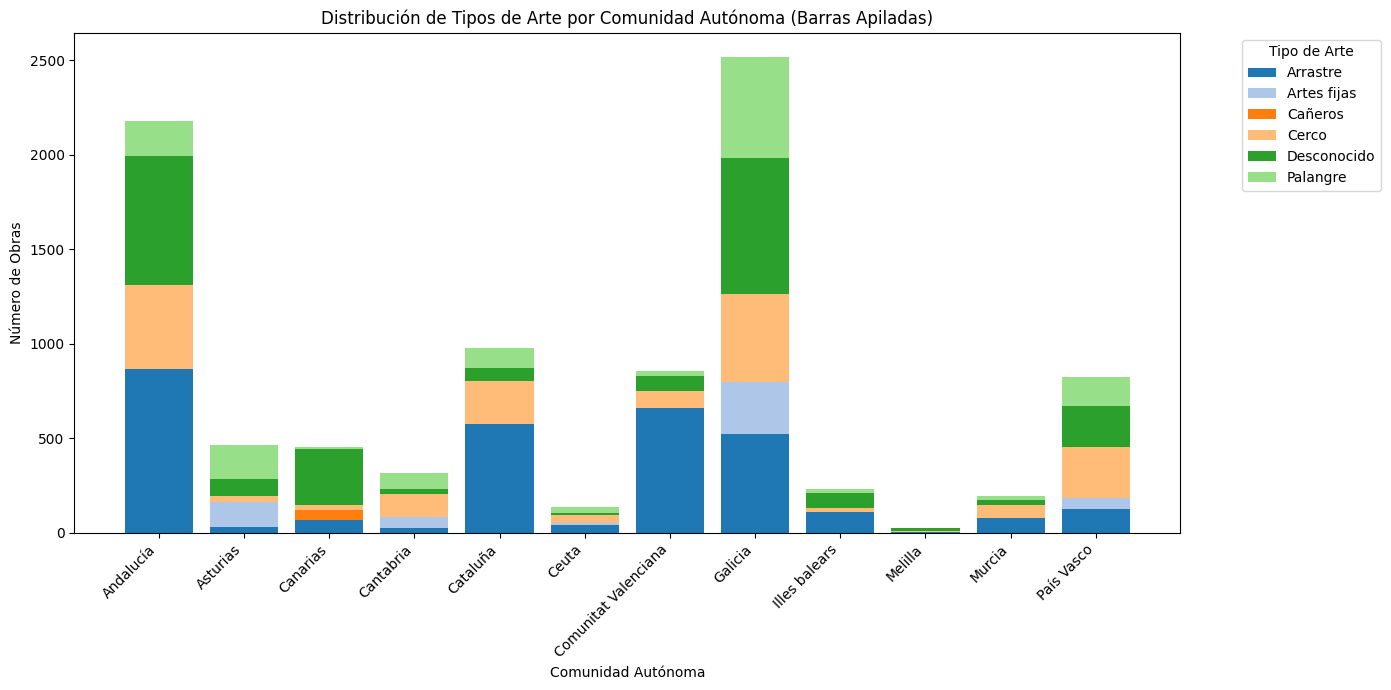

In [44]:
# Agrupar por Comunidad Autónoma y Tipo de Arte, contando las ocurrencias
conteo = data_sin_artes.groupby(['Comunidad Autónoma', 'Tipo de Arte']).size().reset_index(name='count')

# Convertir a formato de tabla para apilar
pivot = conteo.pivot(index='Comunidad Autónoma', columns='Tipo de Arte', values='count').fillna(0)

colores = plt.cm.tab20.colors  # o cualquier otro mapa de colores
columnas = pivot.columns
colores_dict = dict(zip(columnas, colores[:len(columnas)]))

# Crear figura
plt.figure(figsize=(14, 7))

# Apilar barras
bottom = [0] * len(pivot)
for arte in columnas:
    plt.bar(pivot.index, pivot[arte], bottom=bottom, label=arte, color=colores_dict[arte])
    bottom = bottom + pivot[arte]

# Ajustes del gráfico
plt.title('Distribución de Tipos de Arte por Comunidad Autónoma (Barras Apiladas)')
plt.xlabel('Comunidad Autónoma')
plt.ylabel('Número de Obras')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de Arte', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [14]:
grupos = [data[data['Tipo de Arte'] == tipo]['eslora_total'] for tipo in data['Tipo de Arte'].unique()]
stat, p = levene(*grupos)
print(f'Test de Levene (homocedasticidad): p-valor = {p:.4f}')

Test de Levene (homocedasticidad): p-valor = 0.0000


In [18]:
grupos = [grupo['eslora_total'].values for _, grupo in data.groupby('Tipo de Arte')]

# Test de Kruskal-Wallis
stat, p = kruskal(*grupos)
print(f'Test de Kruskal-Wallis: p-valor = {p:.4f}')

Test de Kruskal-Wallis: p-valor = 0.0000


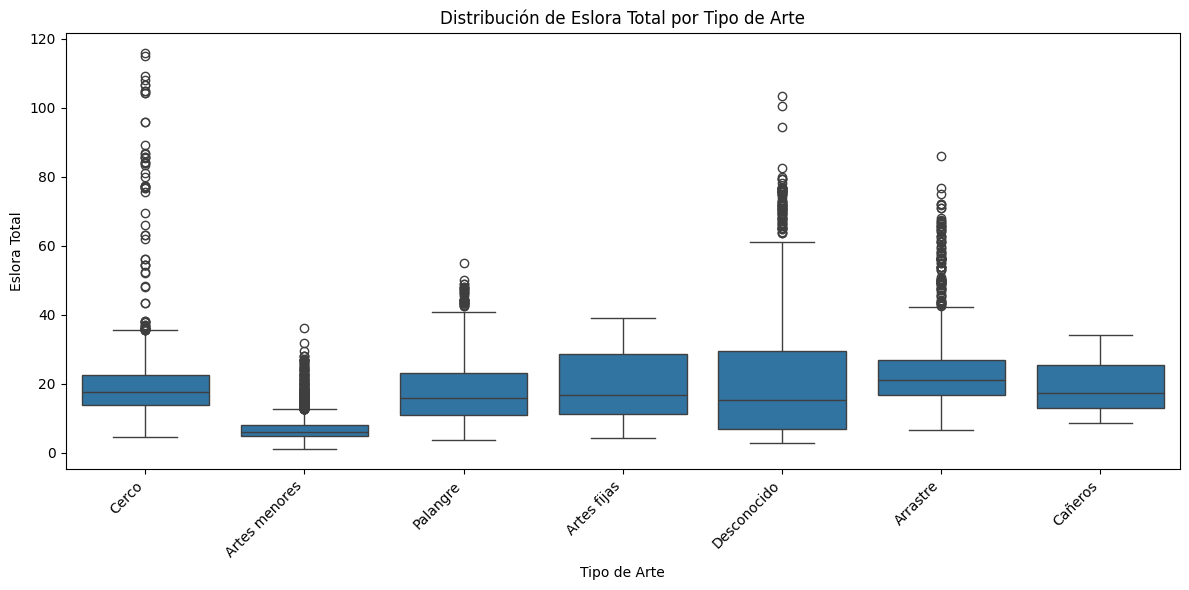

In [47]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Tipo de Arte', y='eslora_total')
plt.title('Distribución de Eslora Total por Tipo de Arte')
plt.xlabel('Tipo de Arte')
plt.ylabel('Eslora Total')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Representación de los resultados a partir de tablas y gráficas. Este apartado se puede responder a lo largo de la práctica, sin necesidad de concentrar todas las representaciones en este apartado. Se debe representar tanto el contenido del dataset para observar las proporciones y distribuciones de las diferentes variables una vez aplicada la etapa de limpieza, como los resultados obtenidos tras la etapa de análisis.

## 6. Resolución del problema. A partir de los resultados obtenidos, ¿cuáles son las conclusiones? ¿Los resultados permiten responder al problema?


## 7. Código. Hay que adjuntar el código, preferiblemente en R, con el que se ha realizado la limpieza, análisis y representación de los datos. Si lo preferís, también podéis trabajar en Python.


## 8. Vídeo. Realizar un breve vídeo explicativo de la práctica (máximo 10 minutos), donde ambos integrantes del equipo expliquen con sus propias palabras el desarrollo de la práctica, basándose en las preguntas del enunciado para justificar y explicar el código desarrollado. Este vídeo se deberá entregar a través de un enlace al Google Drive de la UOC (https://drive.google.com/…), junto con enlace al repositorio Git entregado.